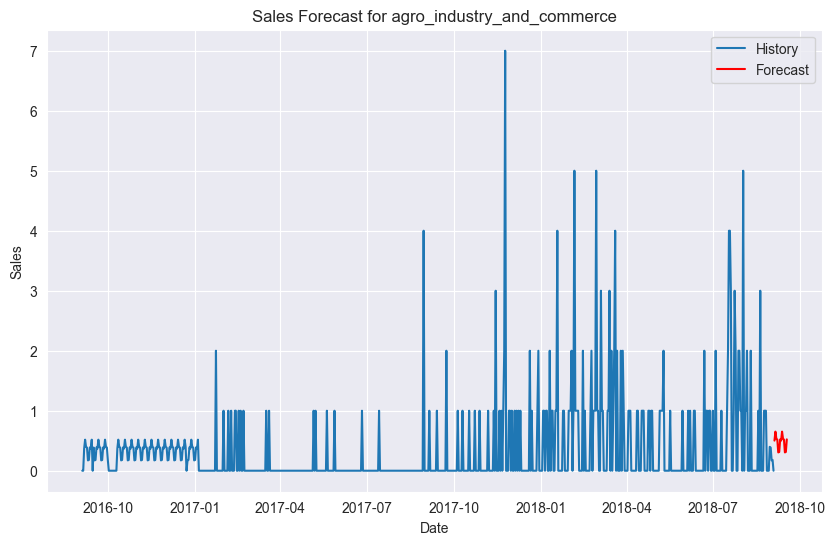

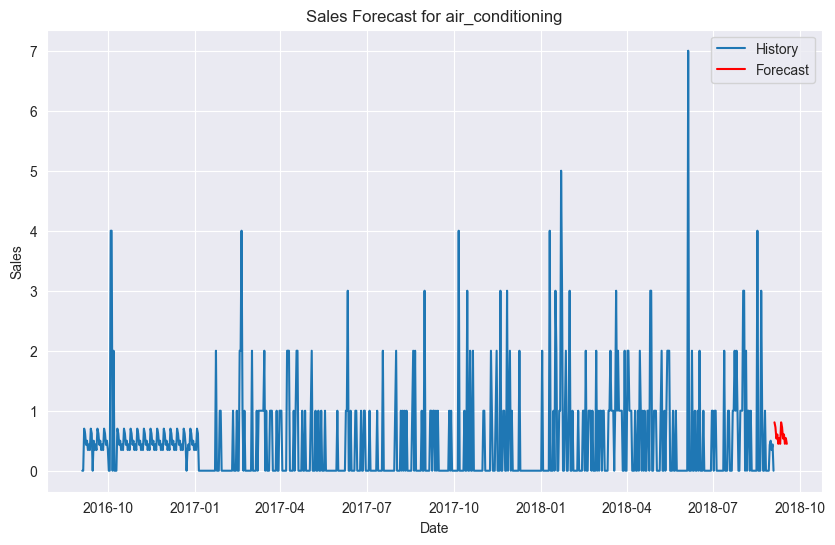

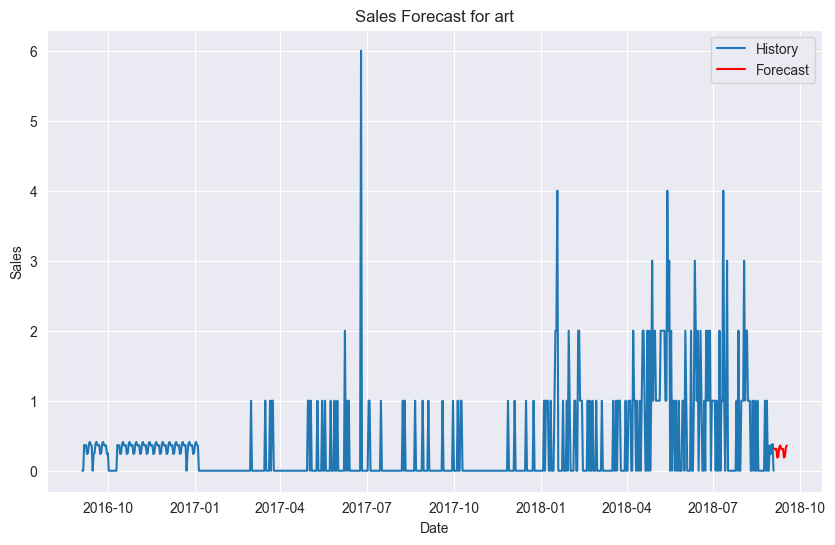

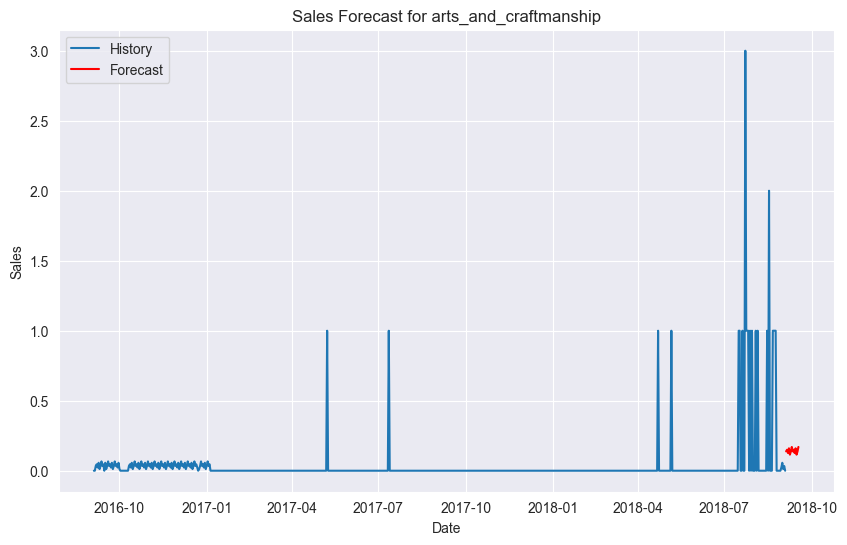

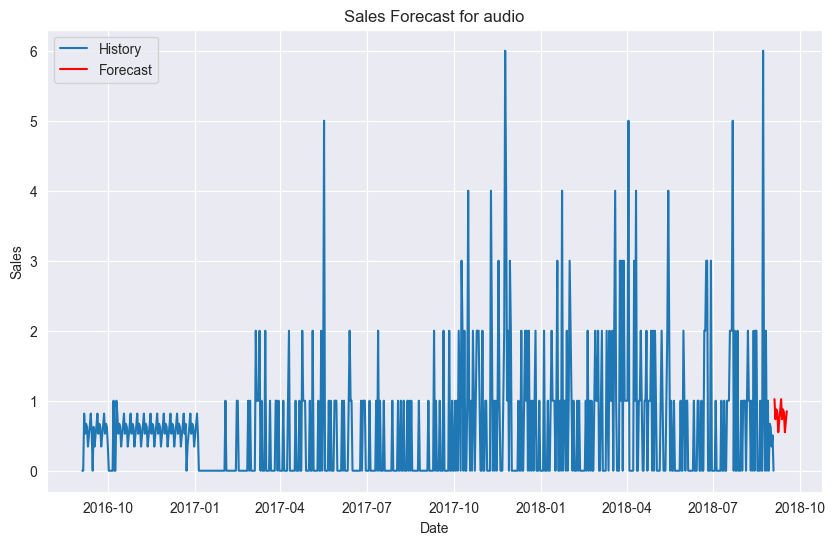

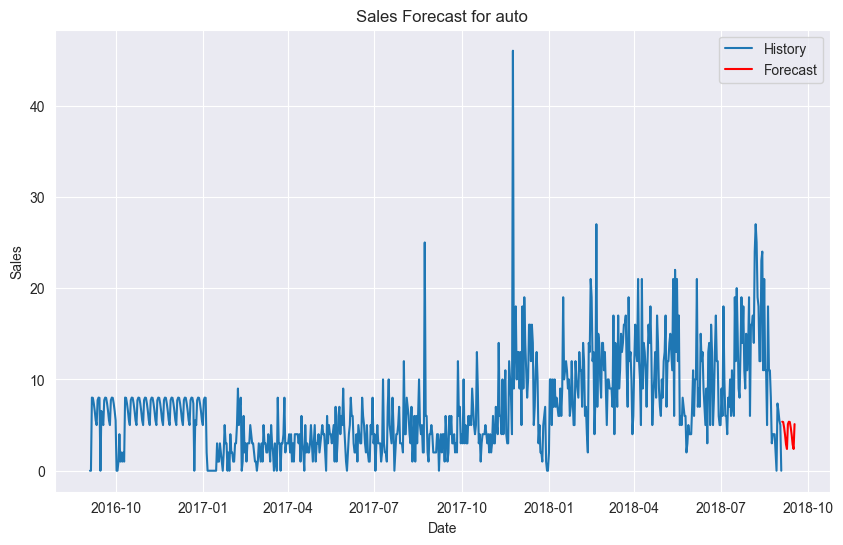

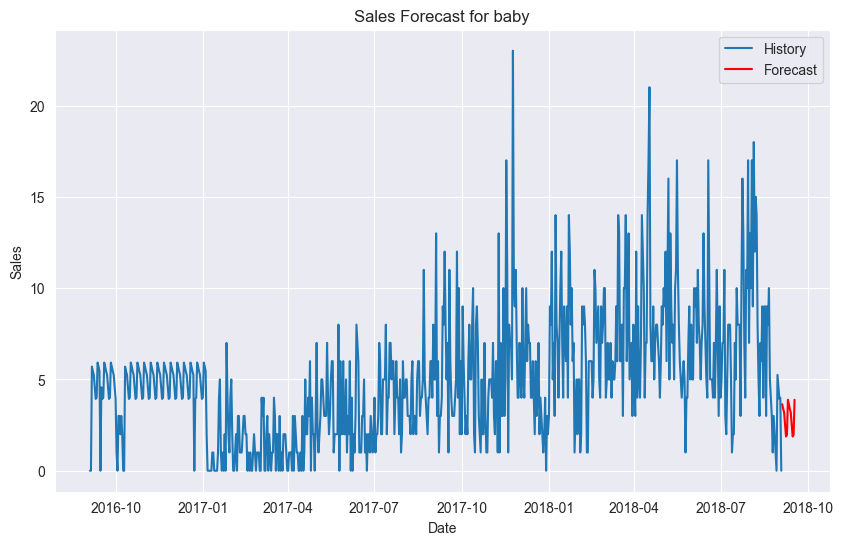

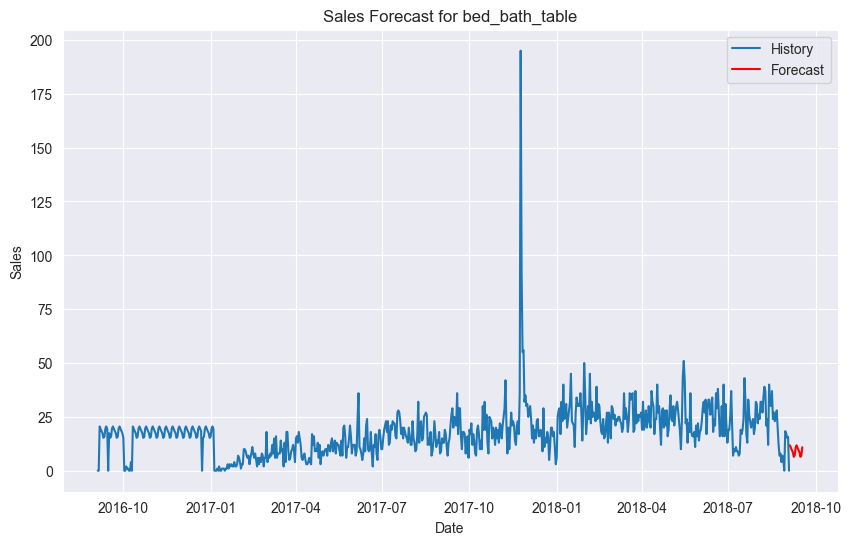

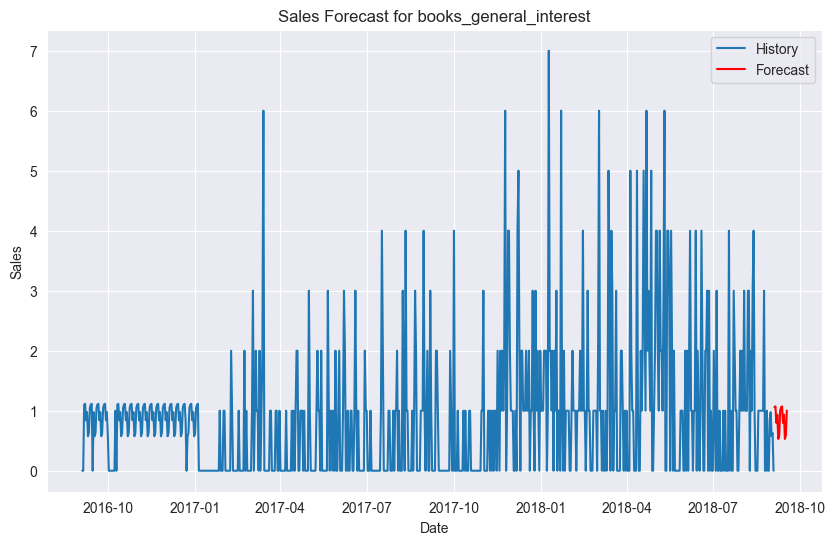

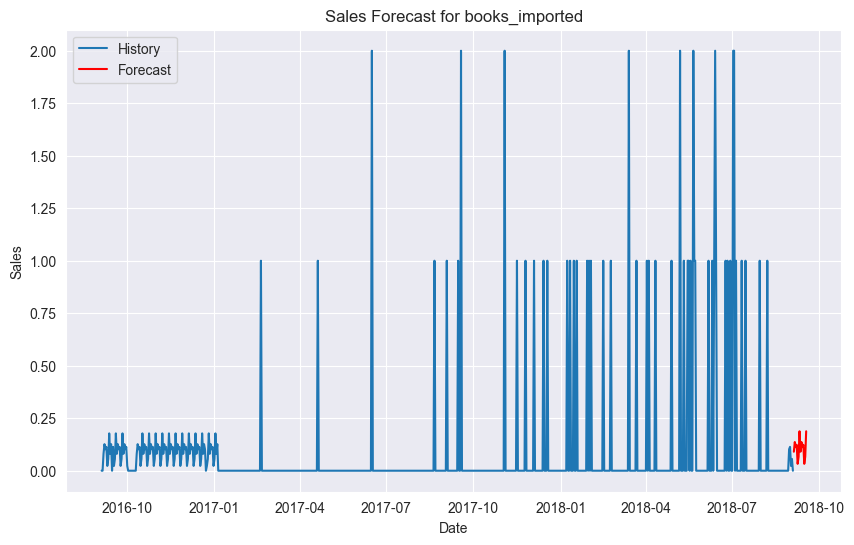

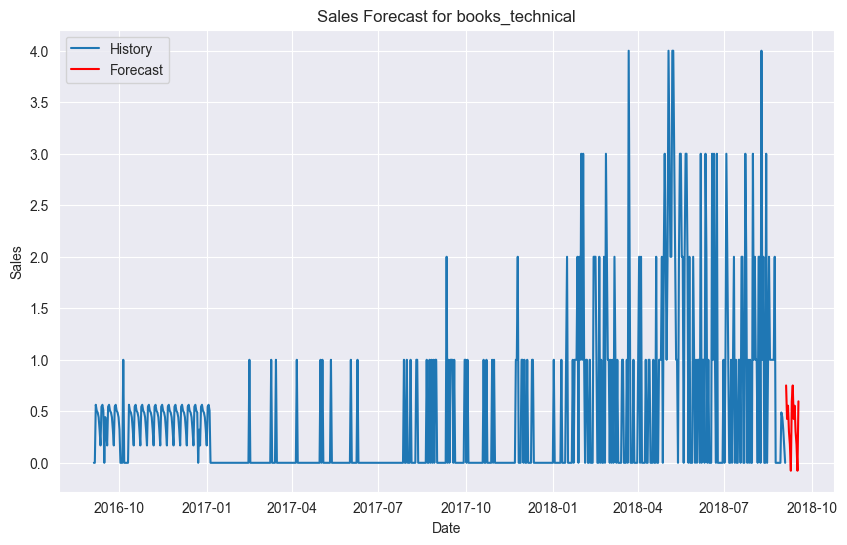

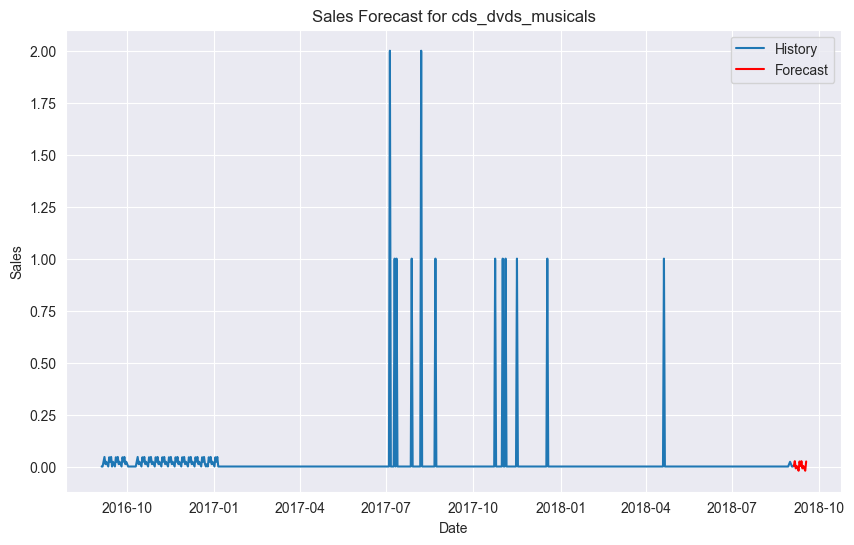

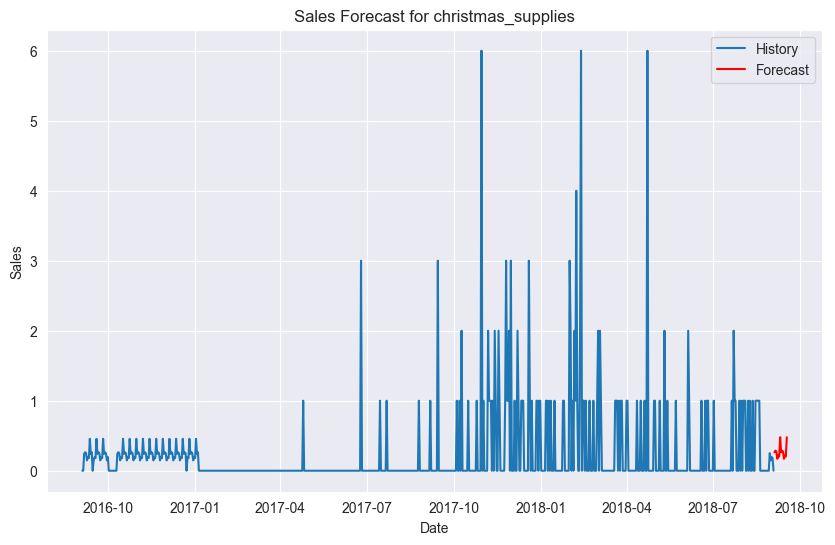

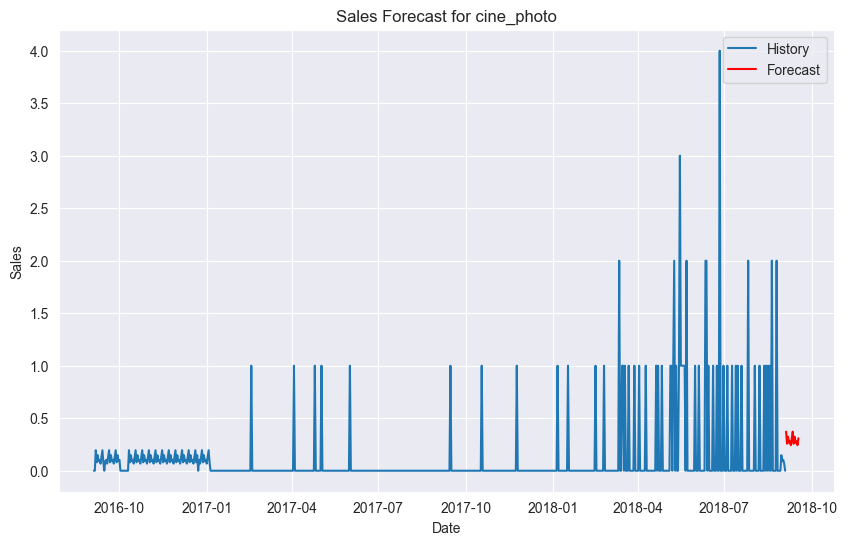

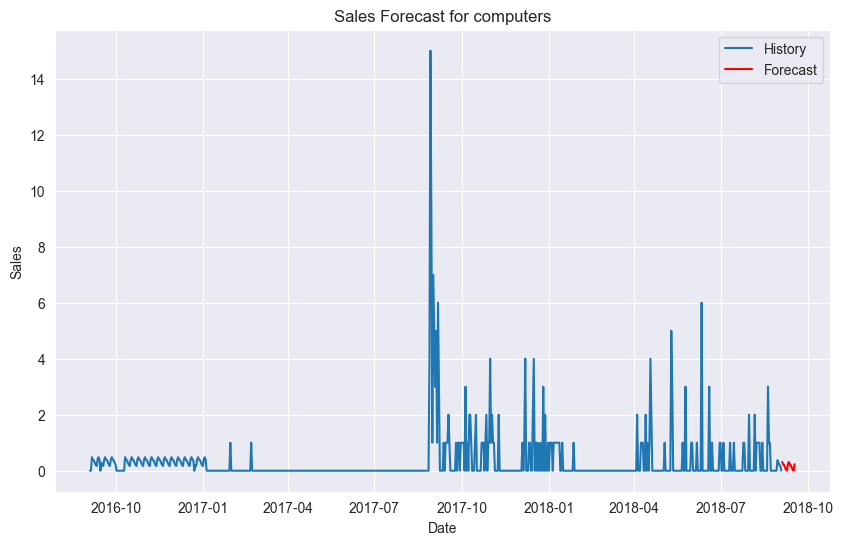

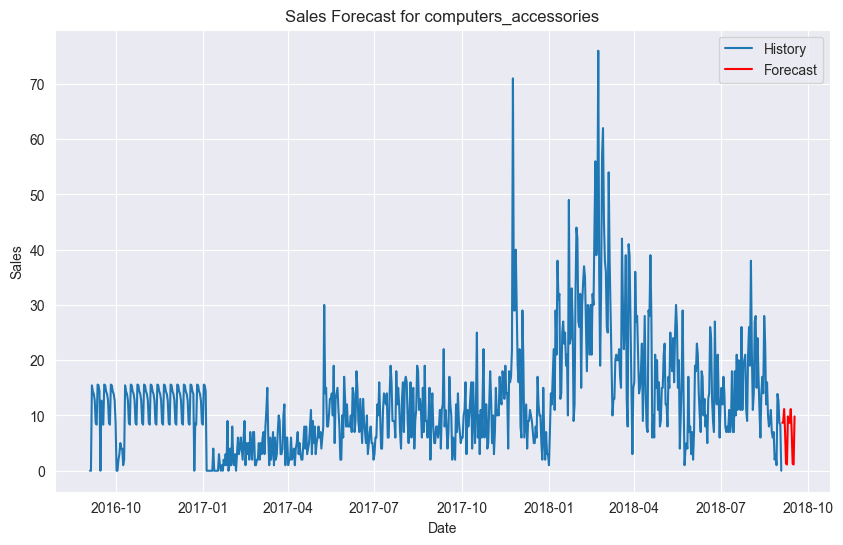

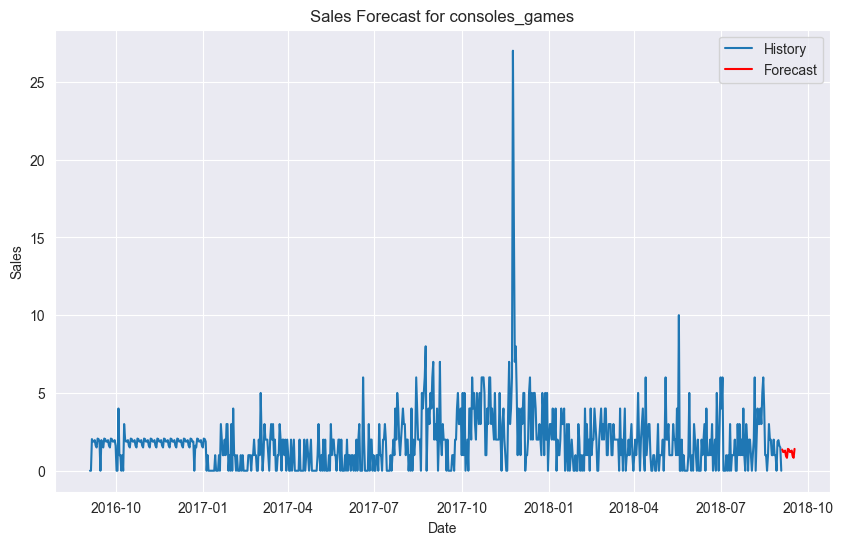

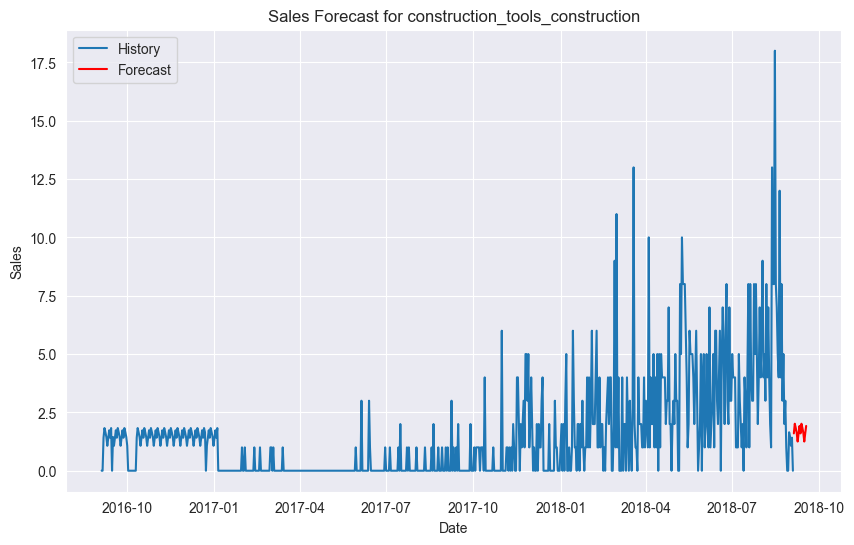

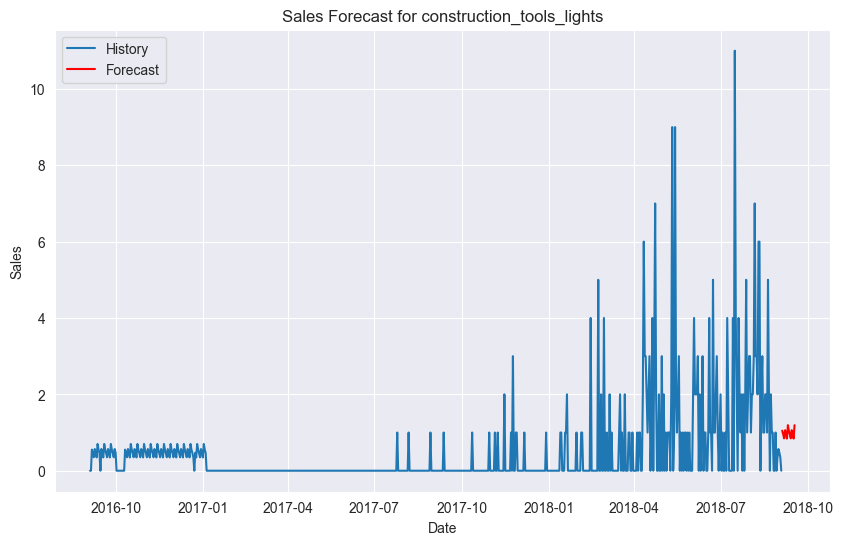

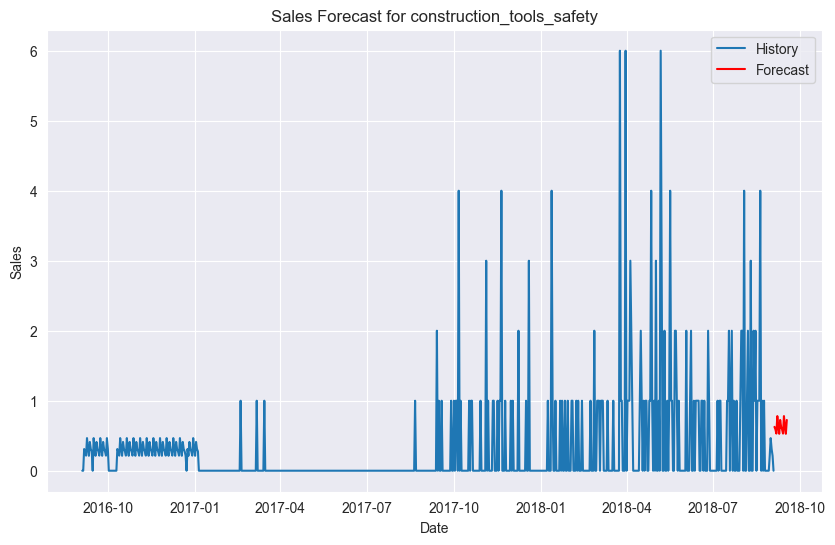

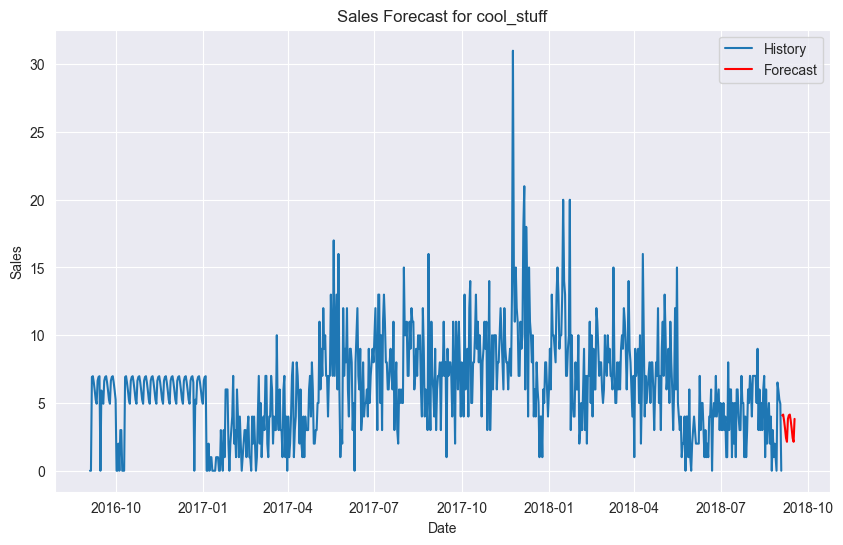

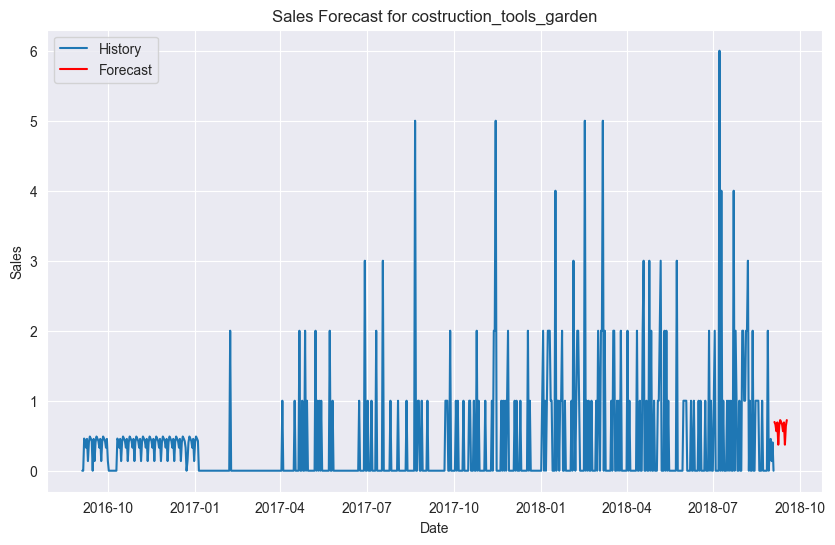

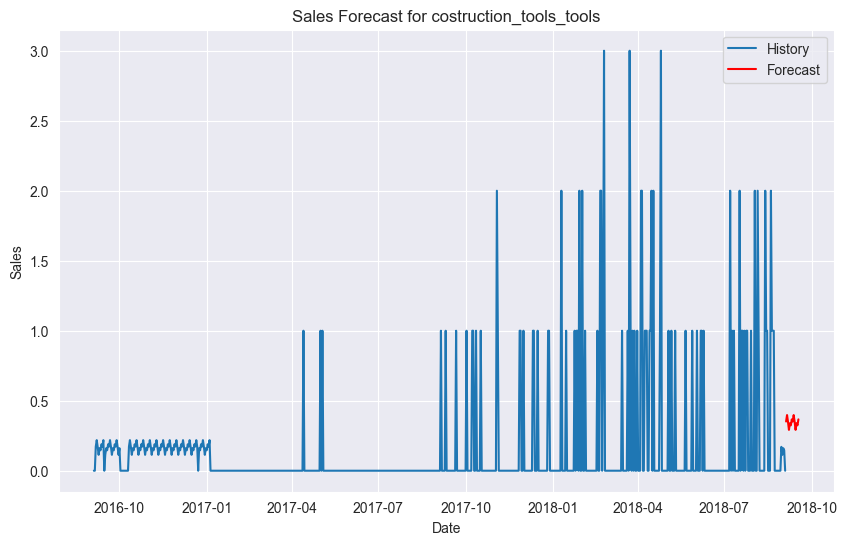

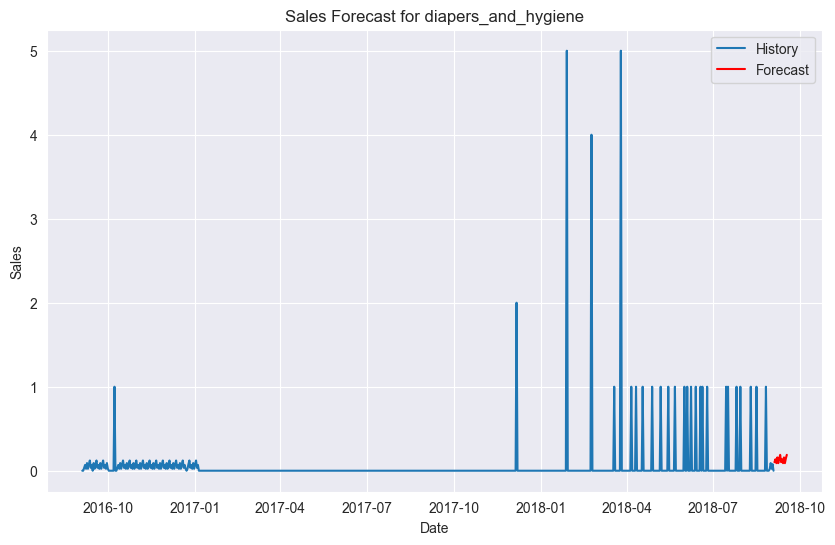

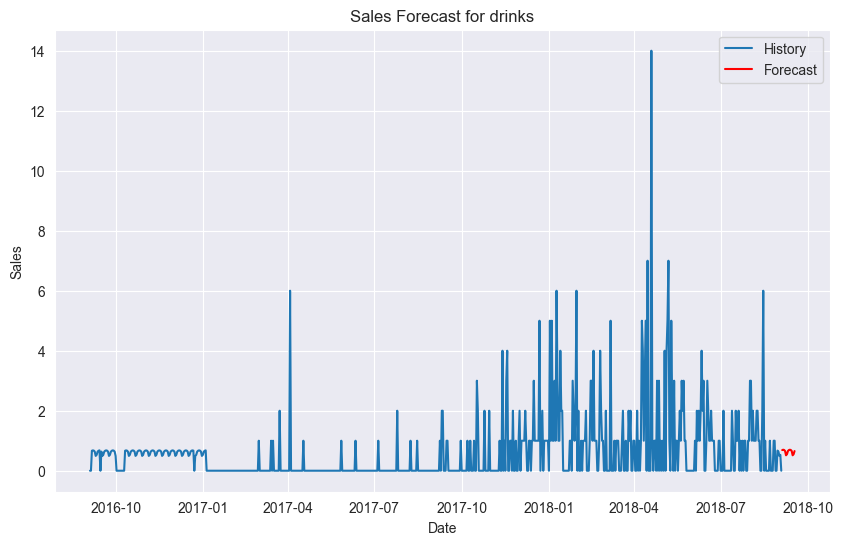

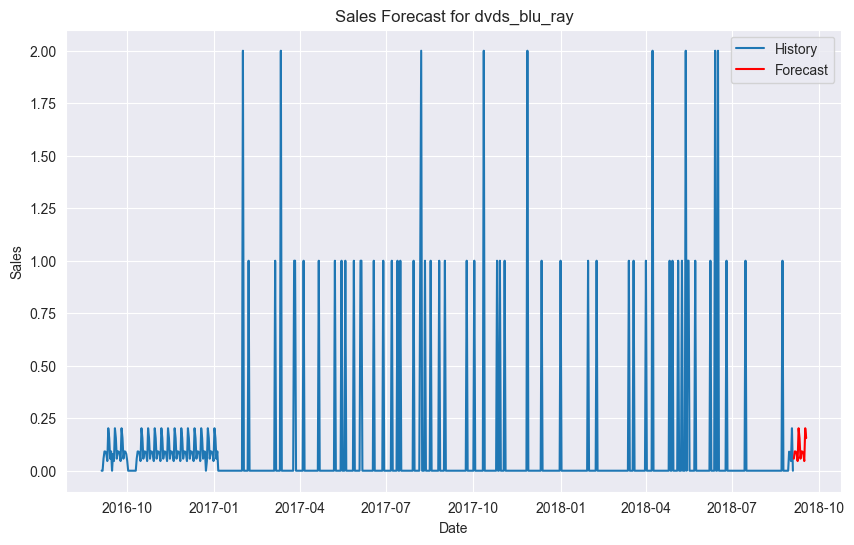

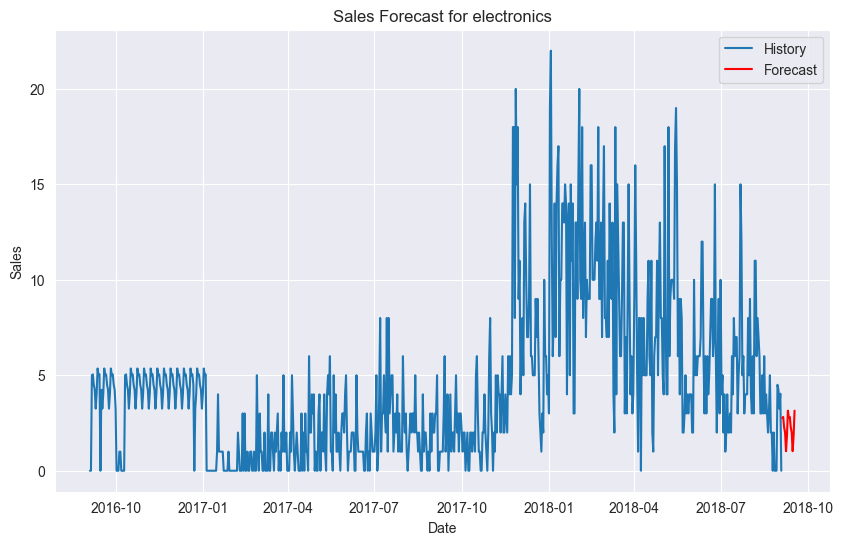

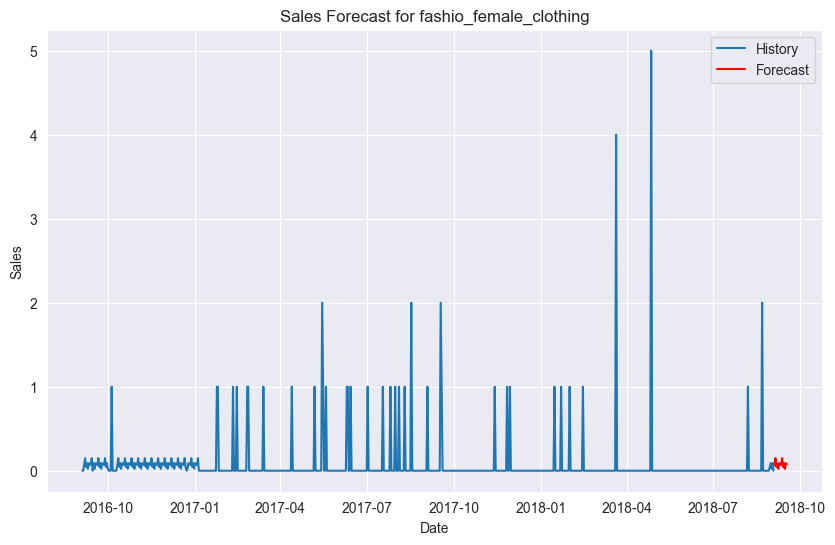

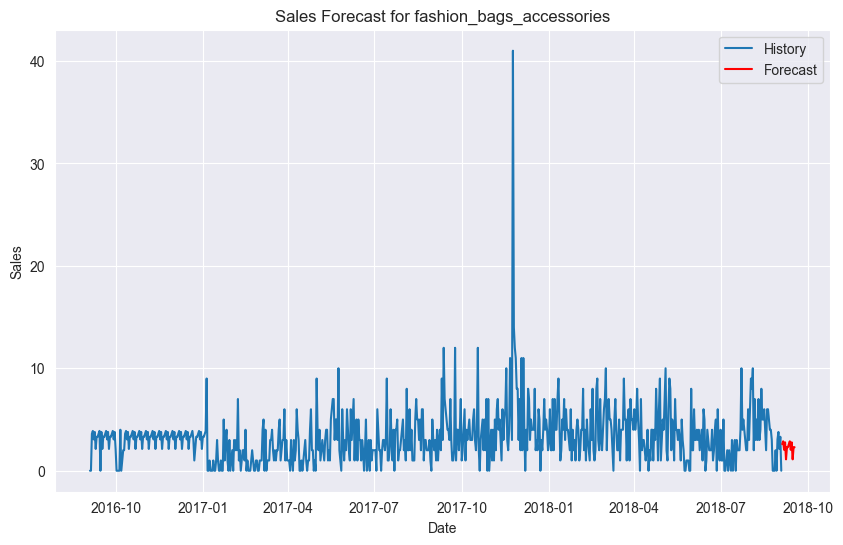

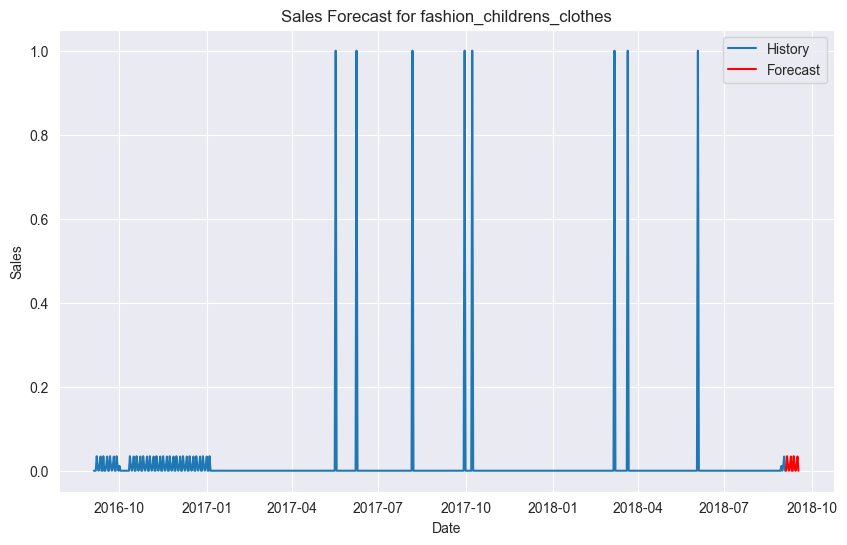

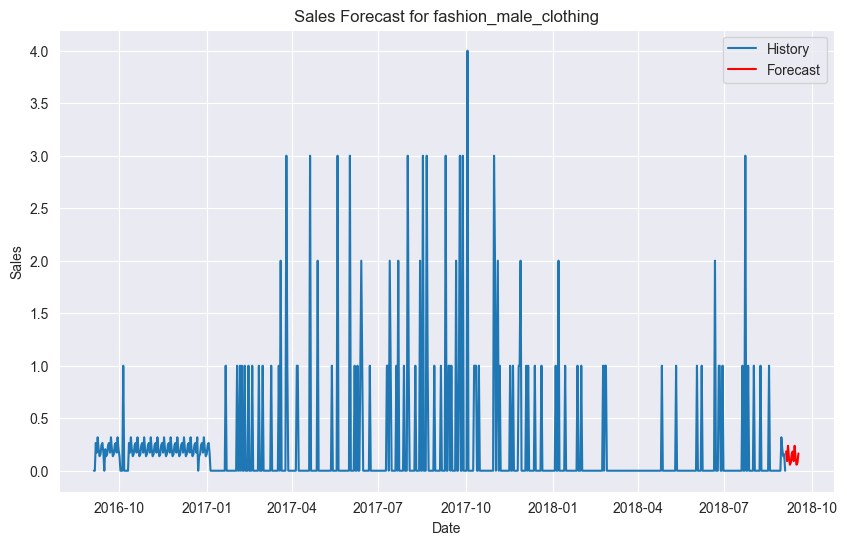

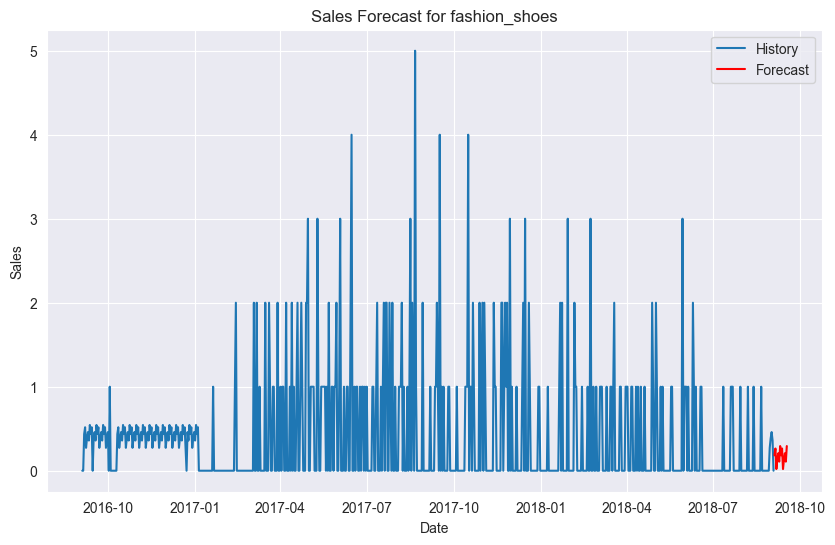

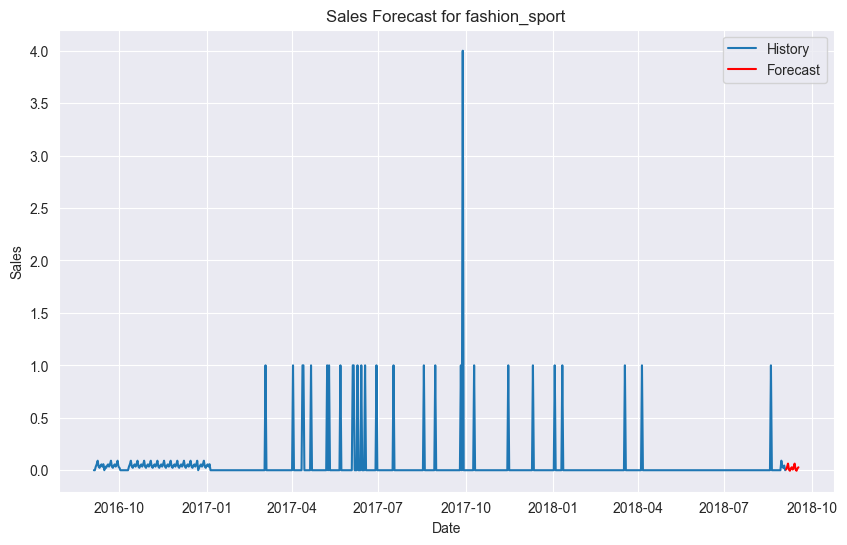

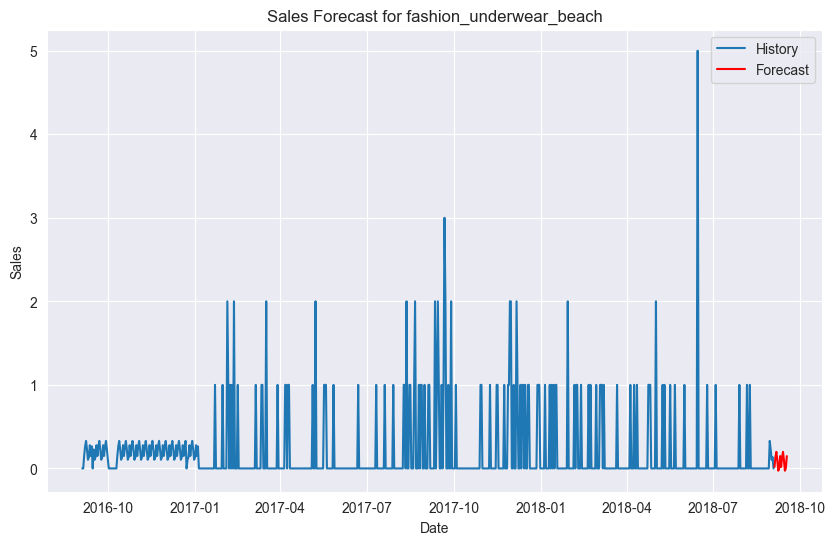

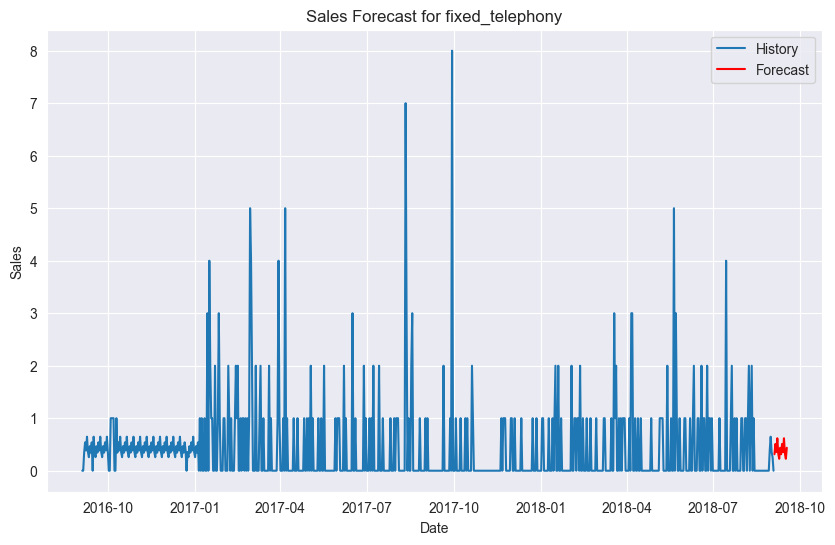

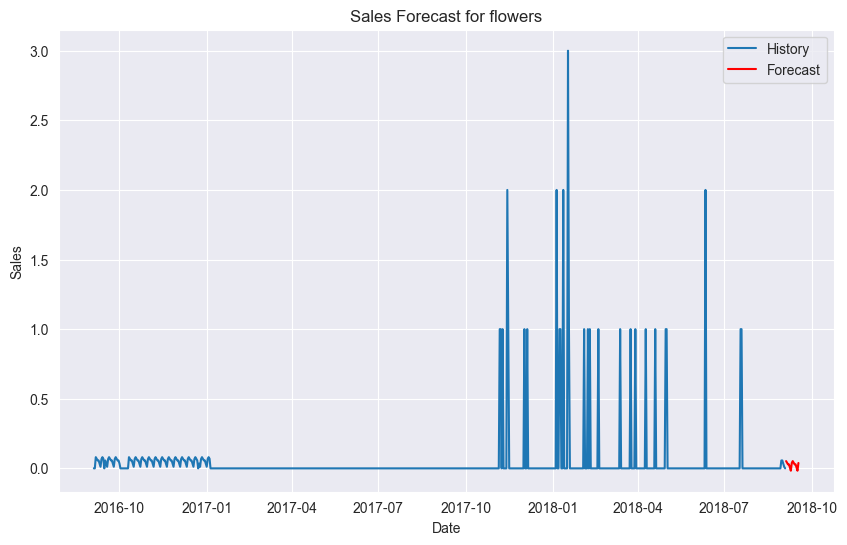

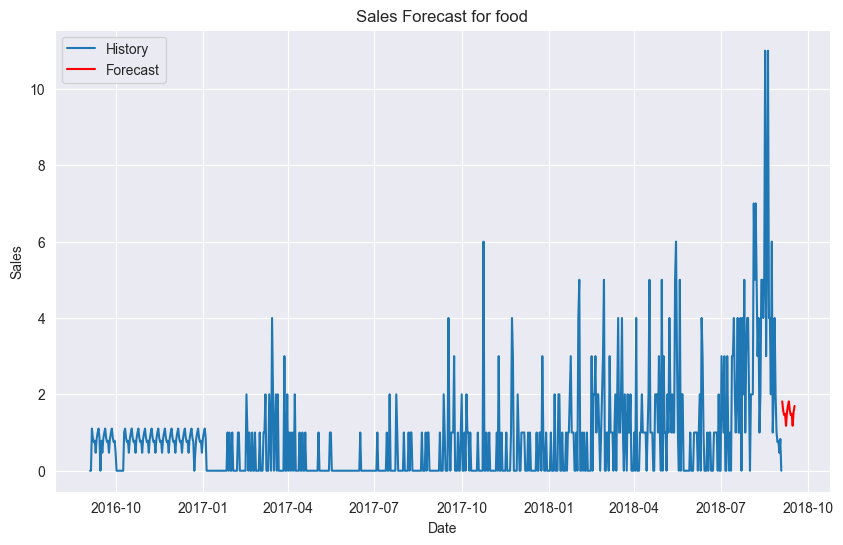

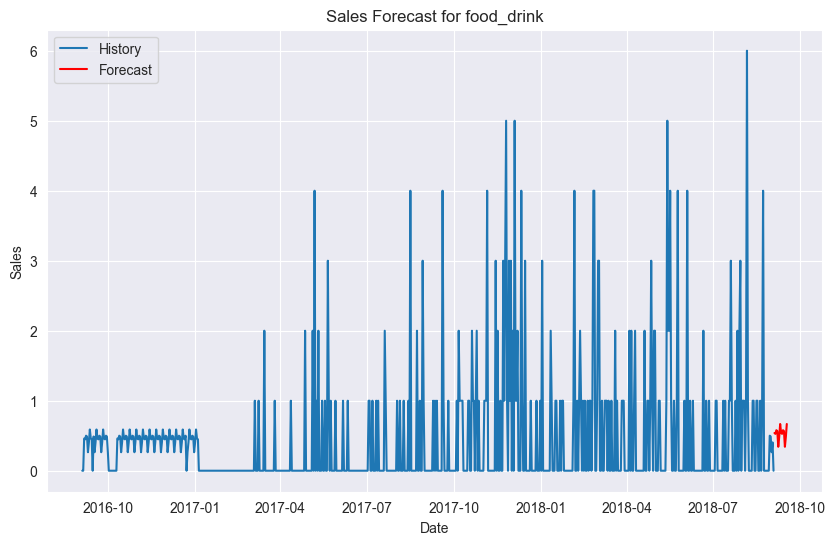

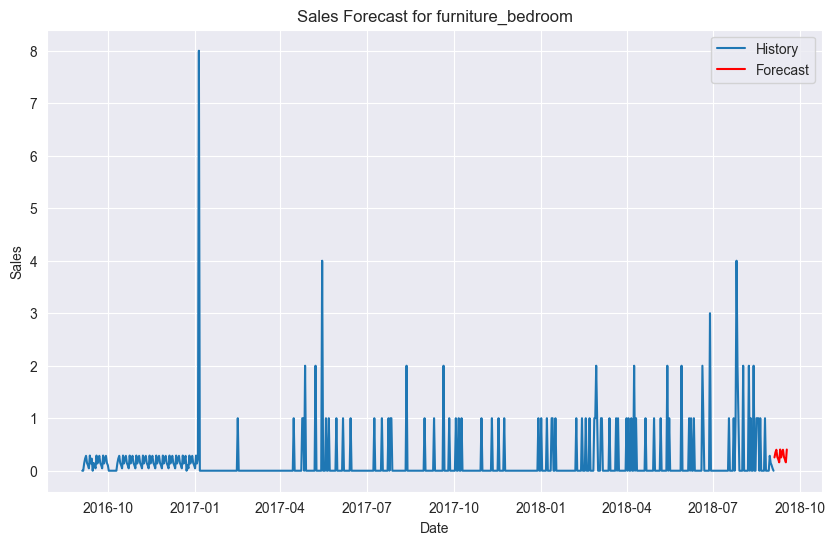

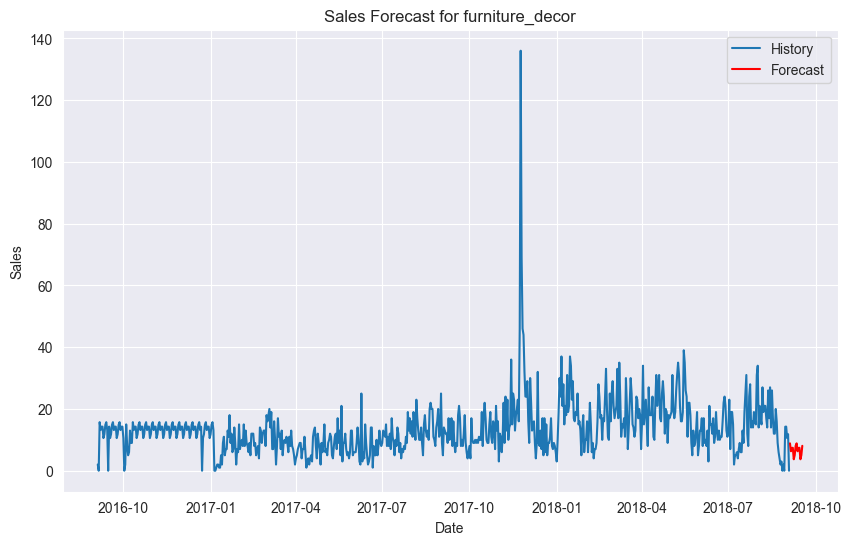

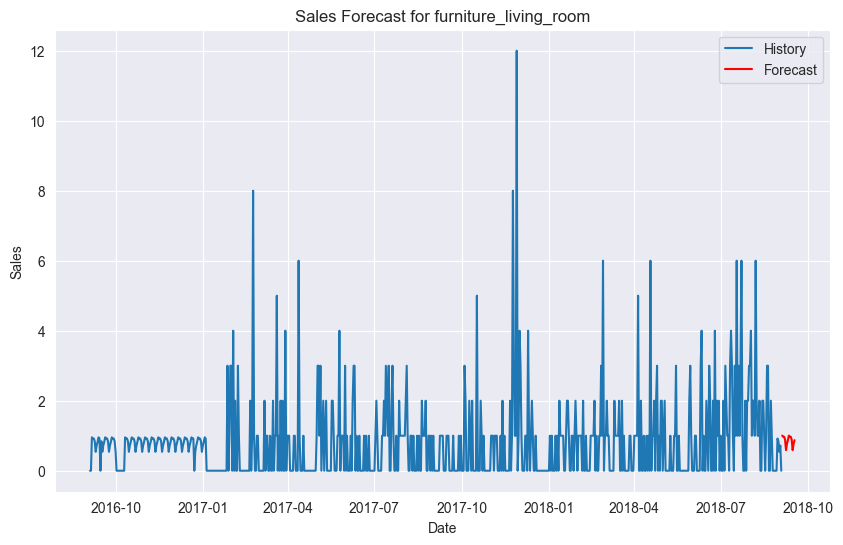

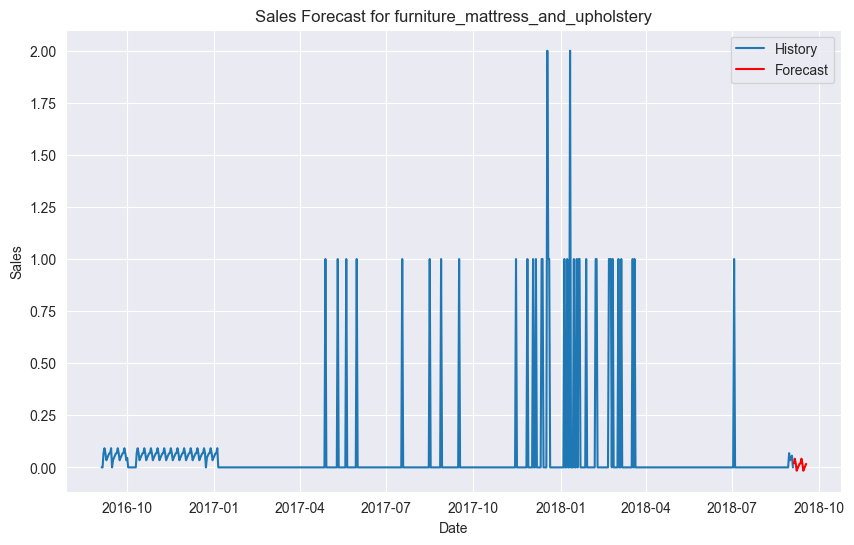

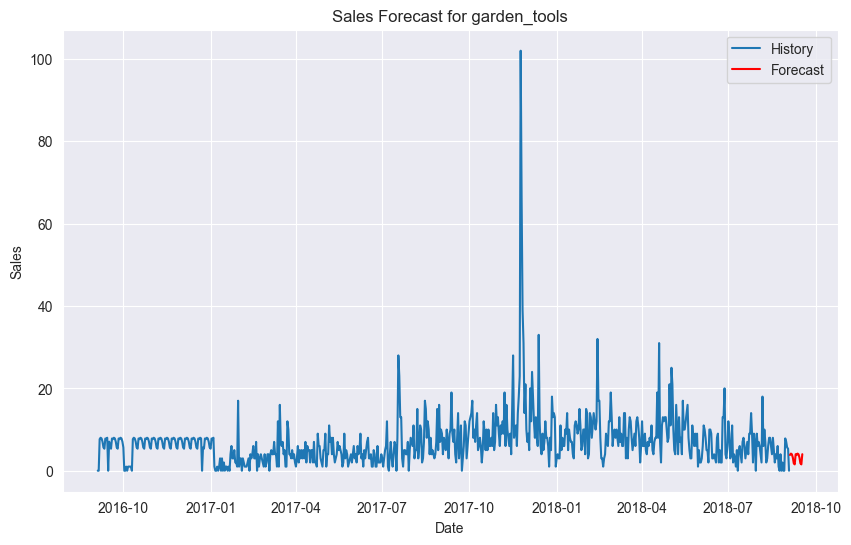

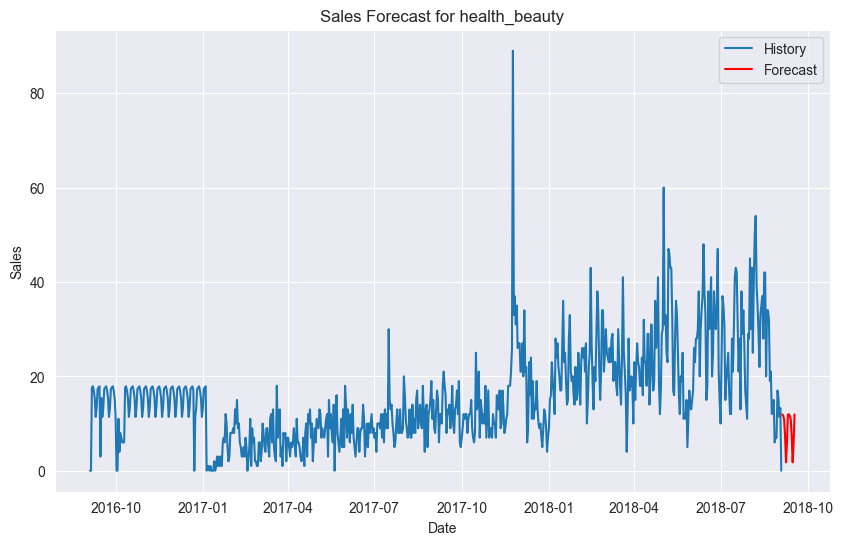

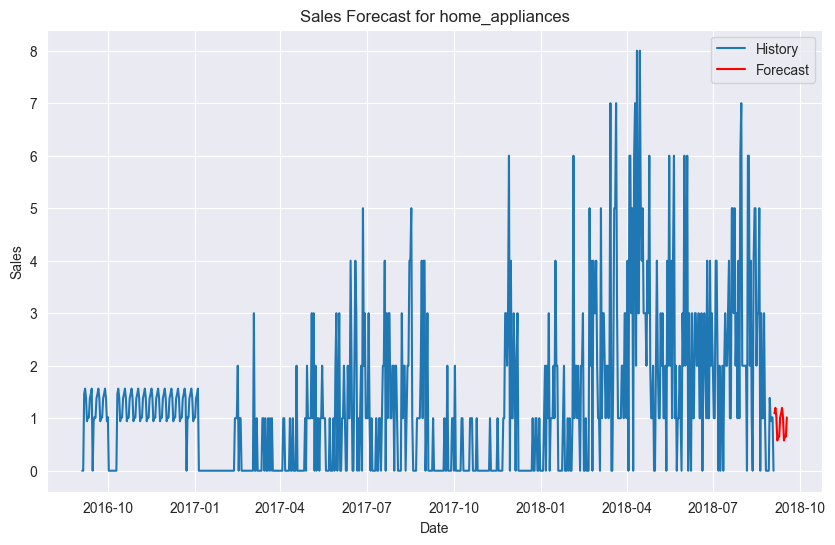

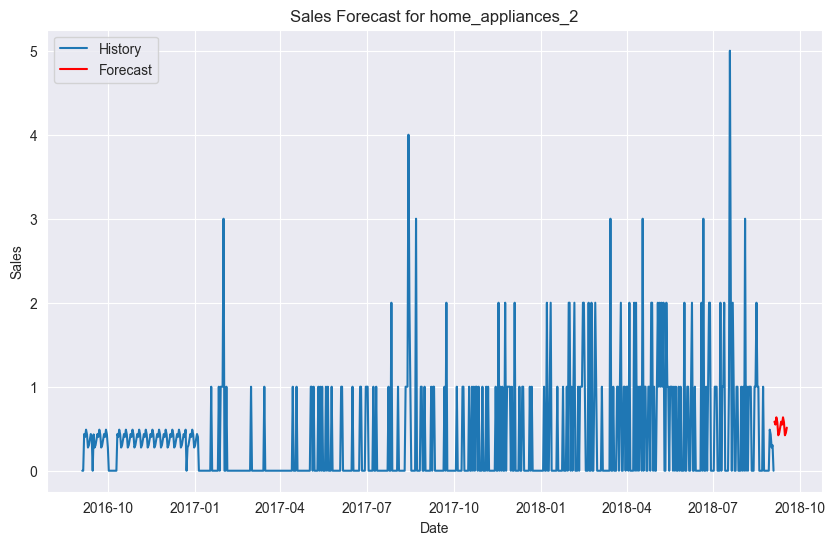

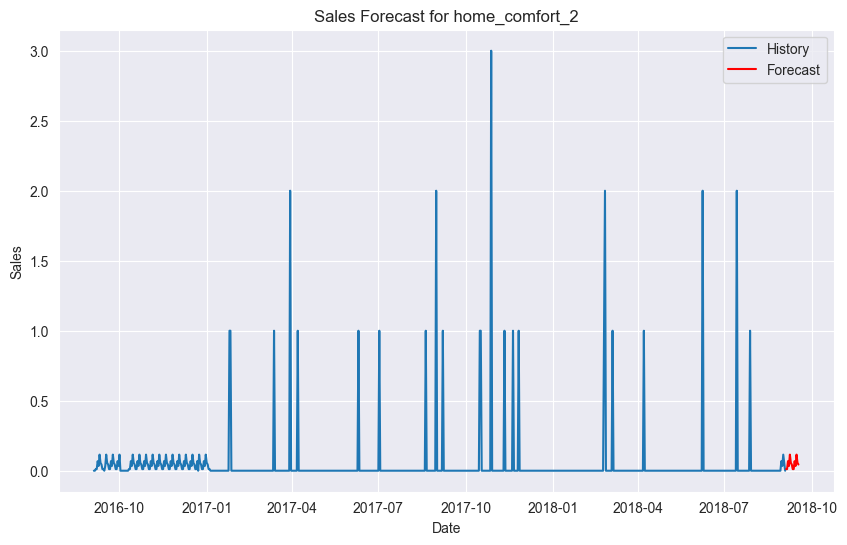

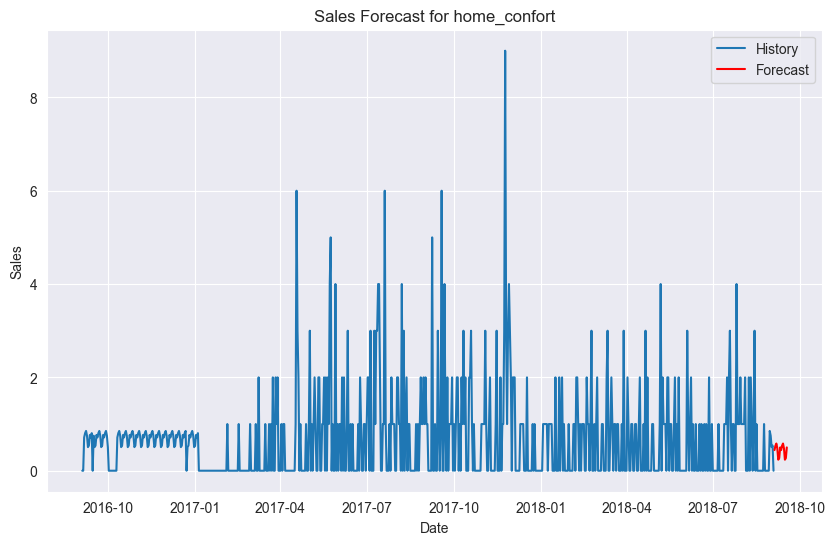

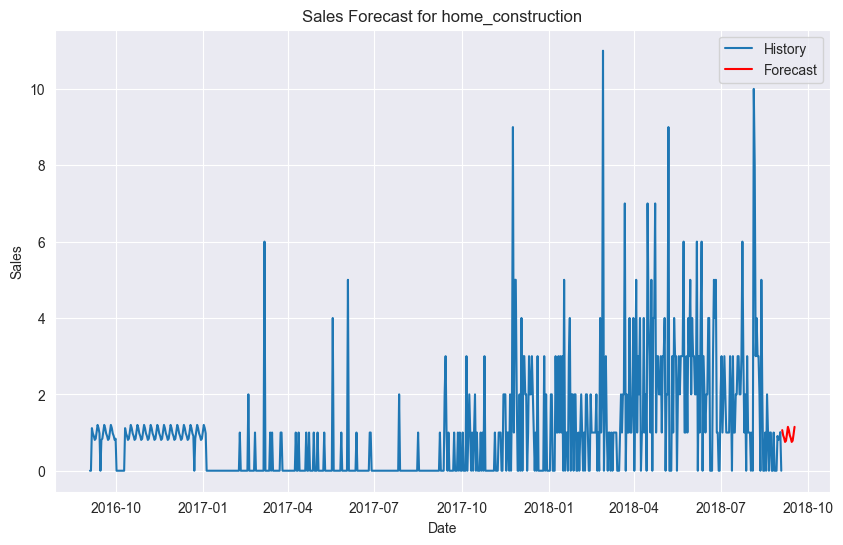

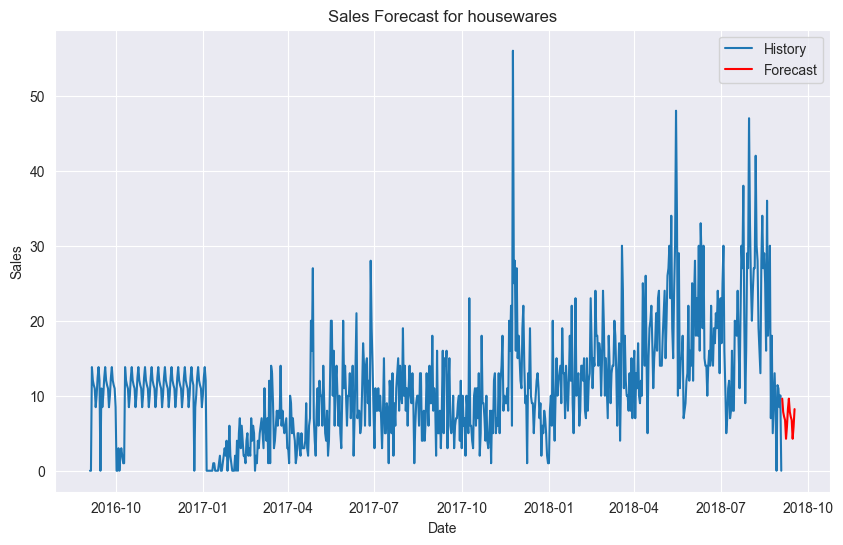

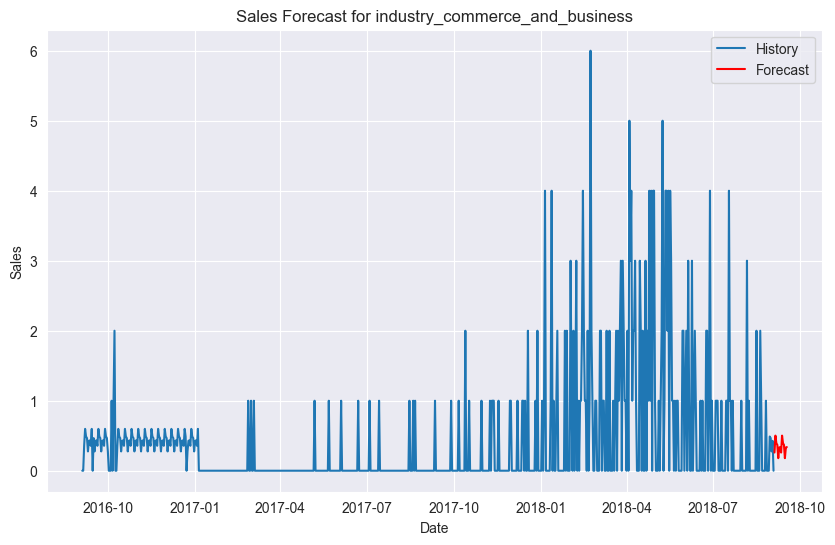

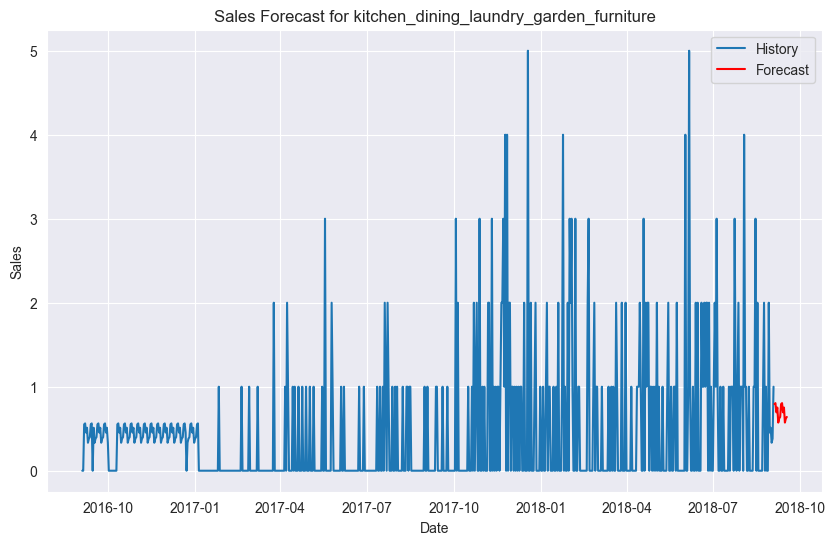

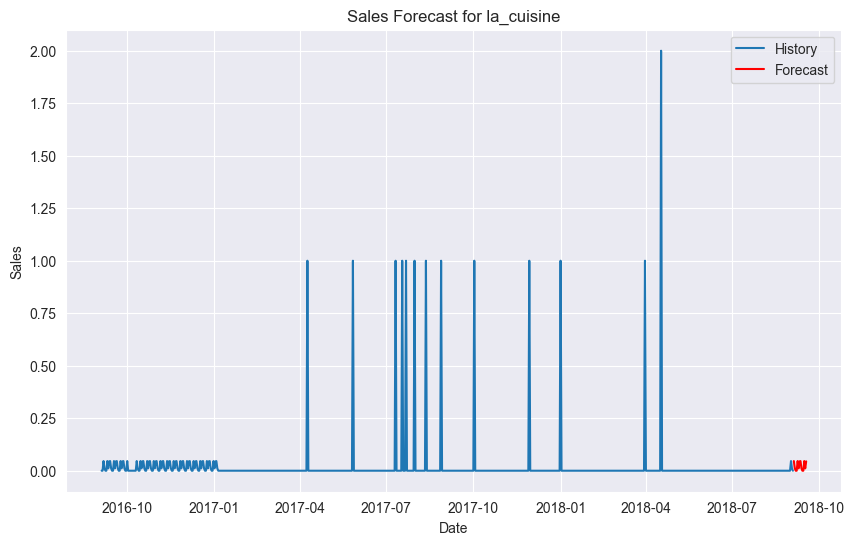

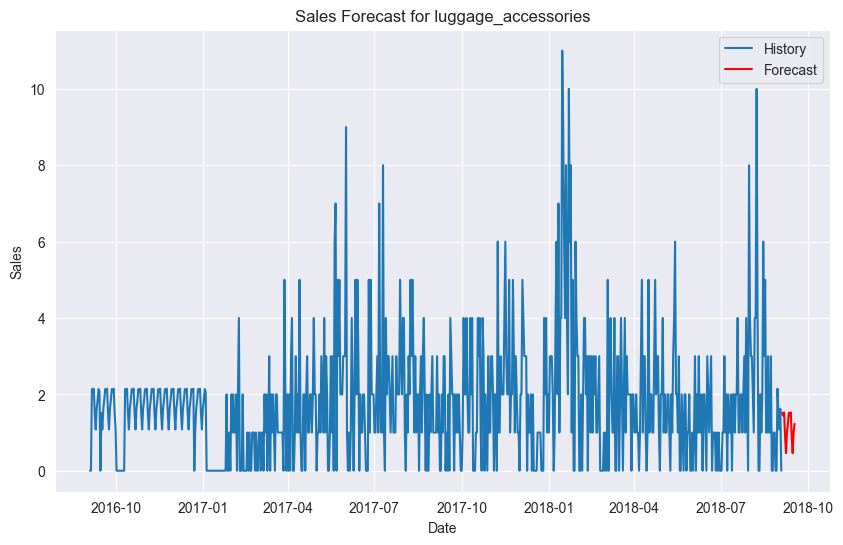

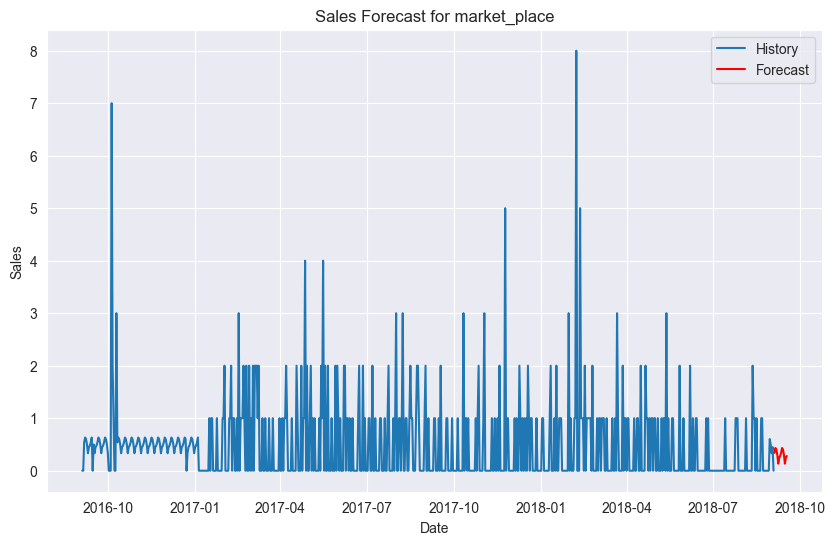

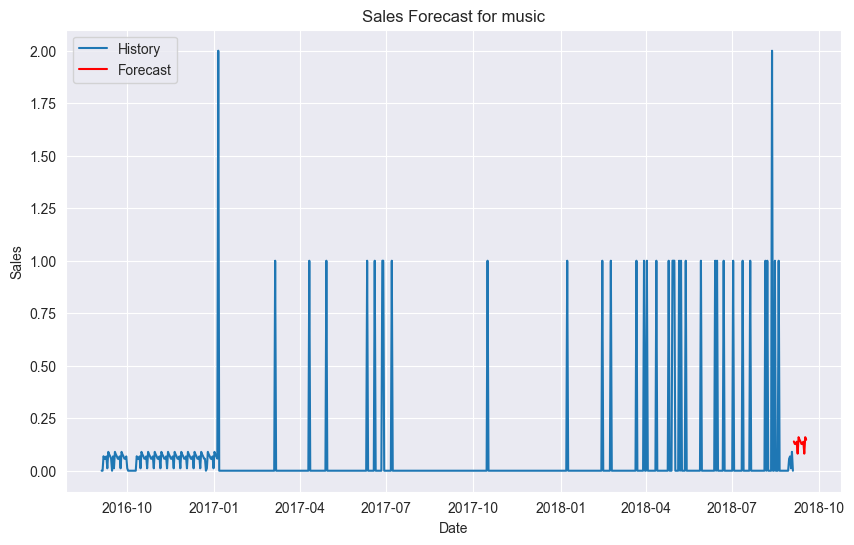

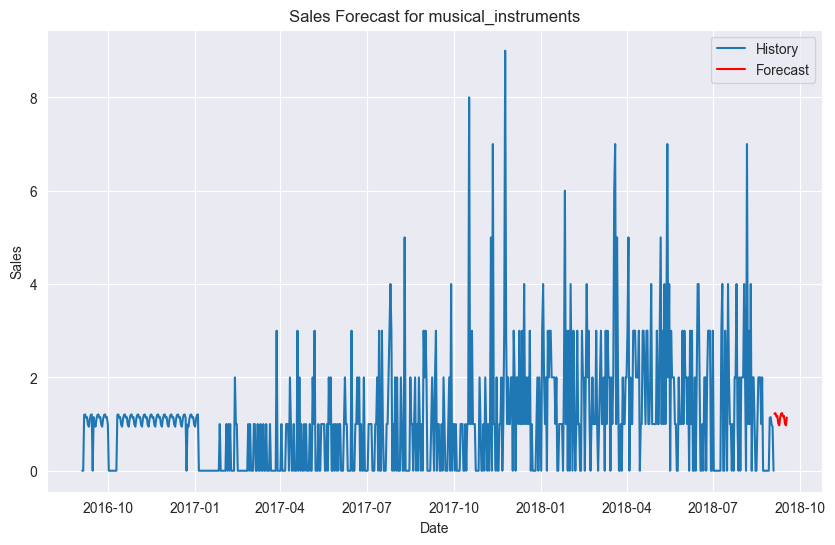

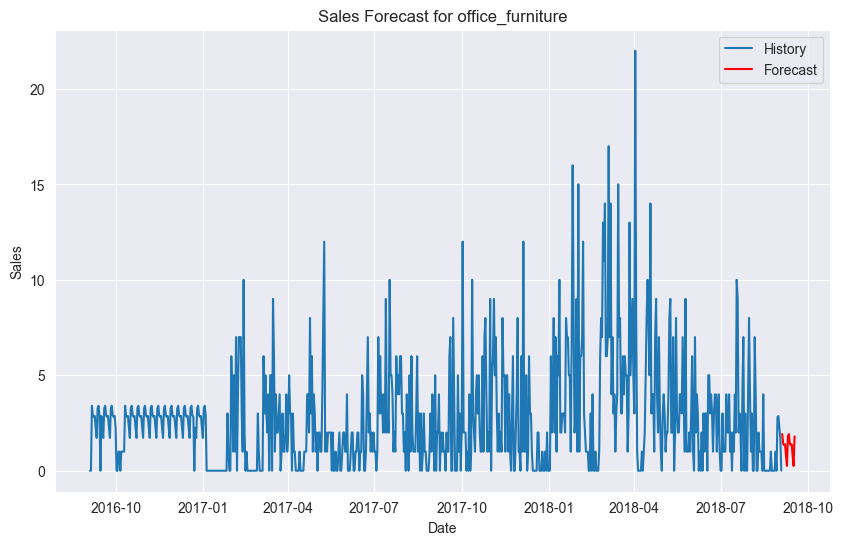

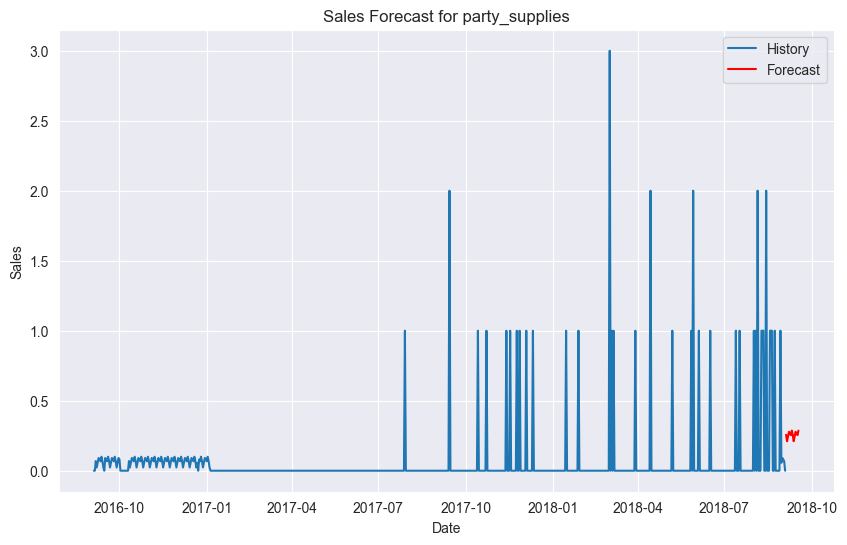

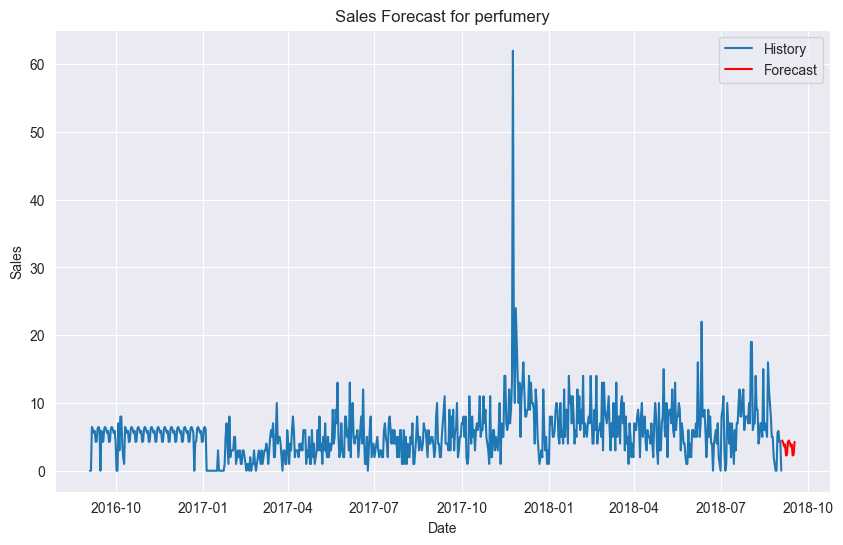

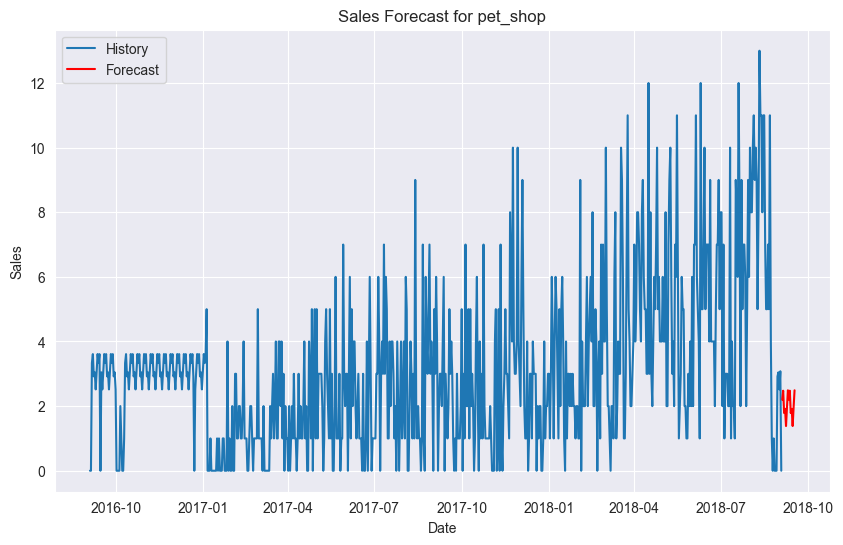

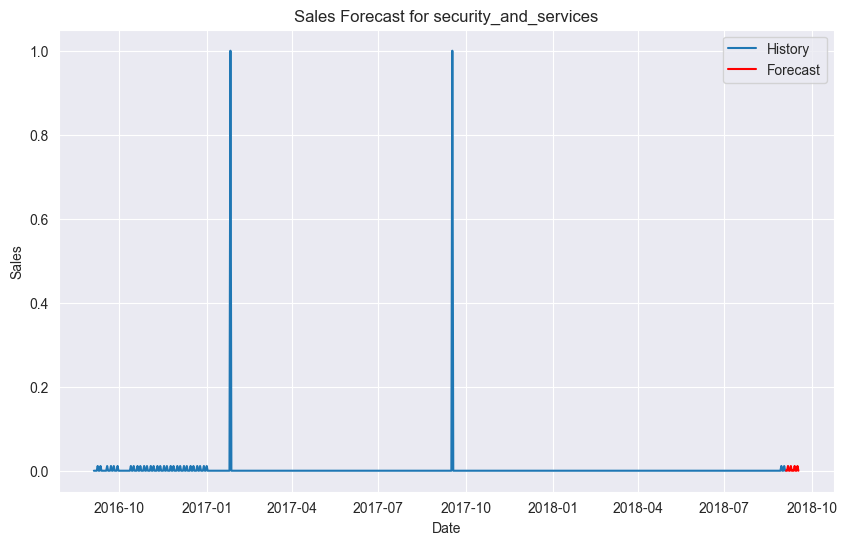

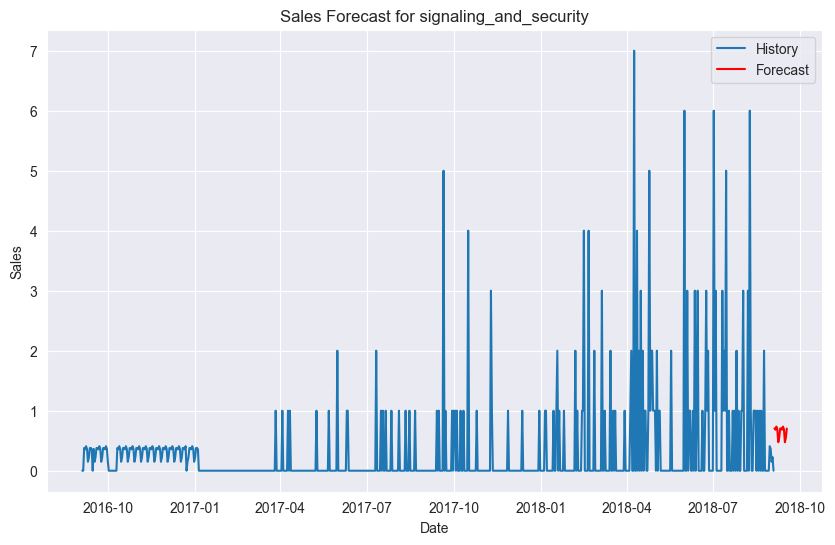

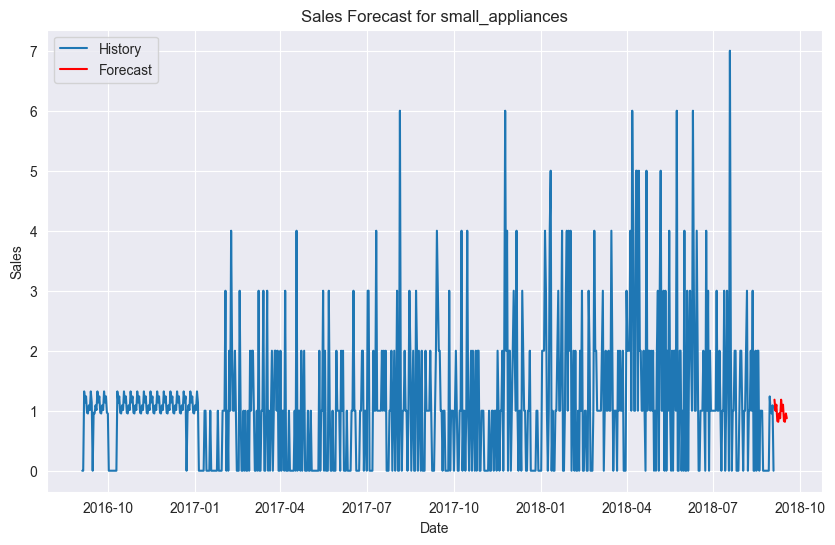

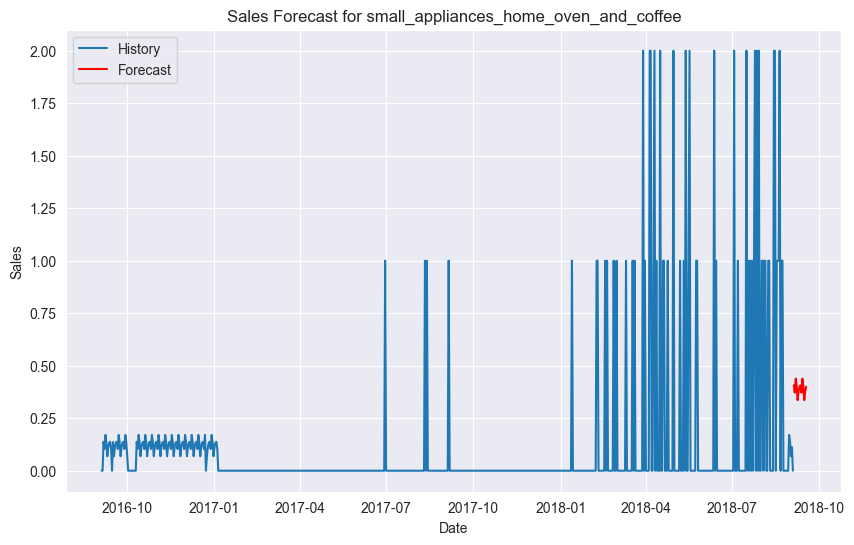

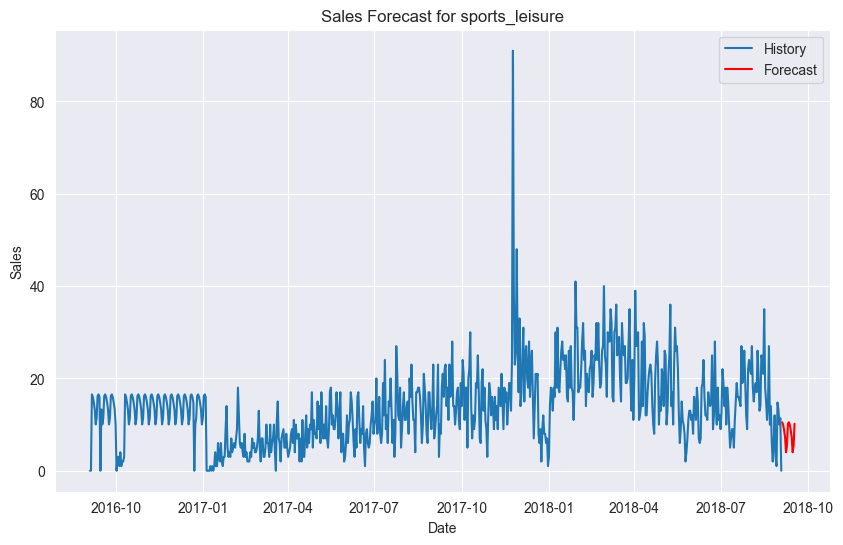

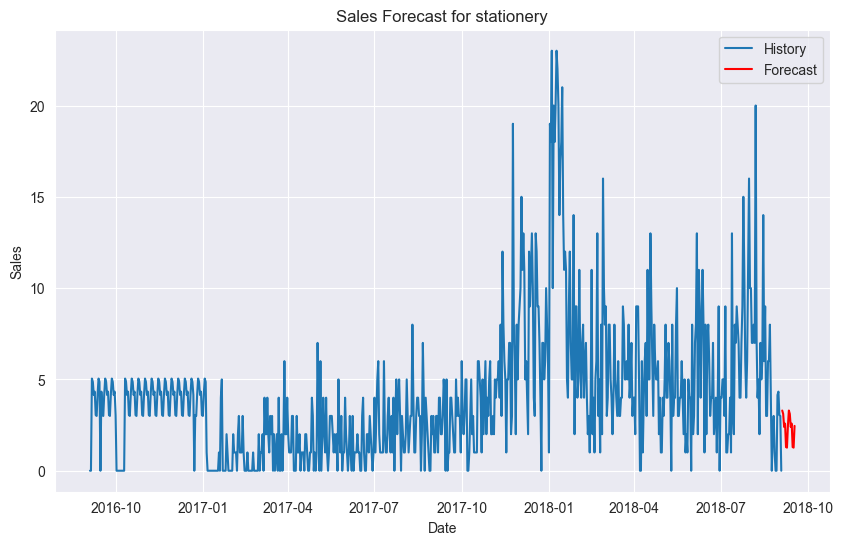

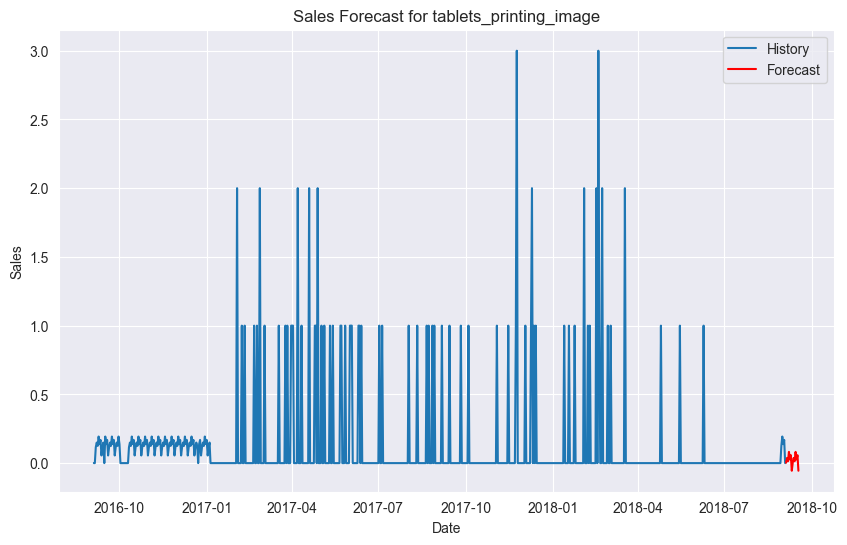

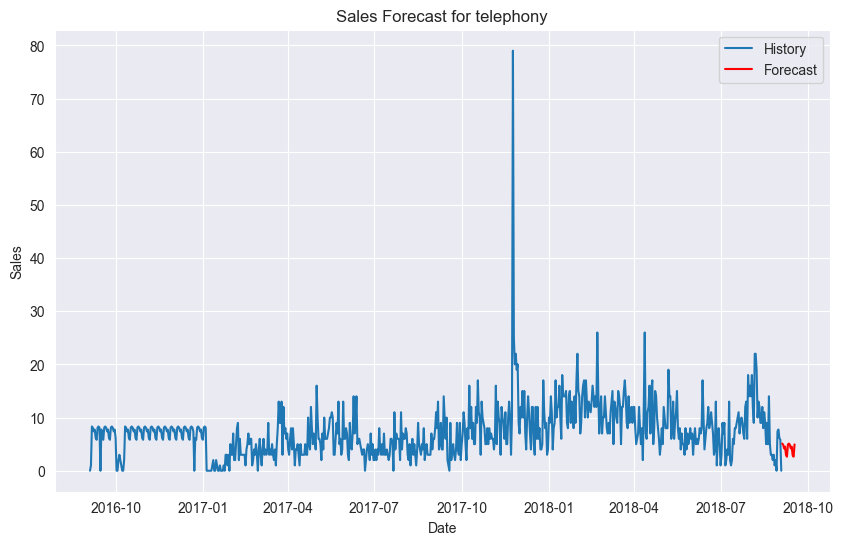

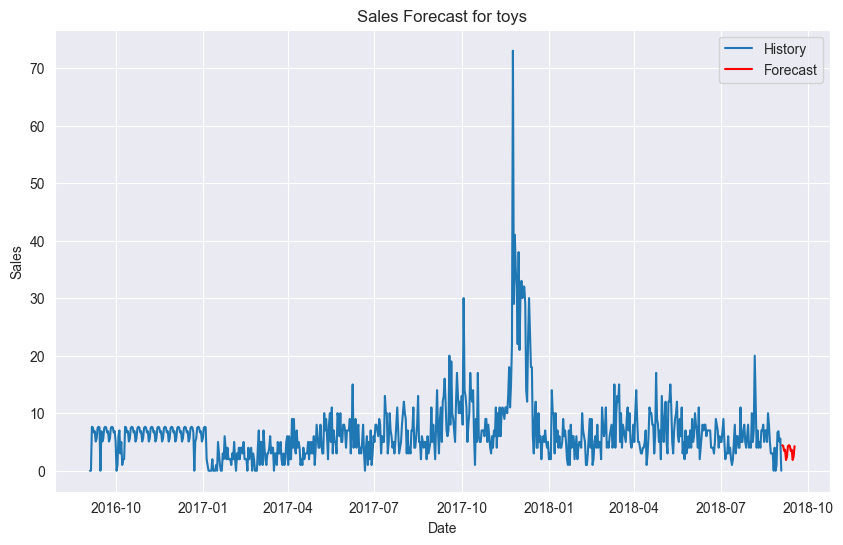

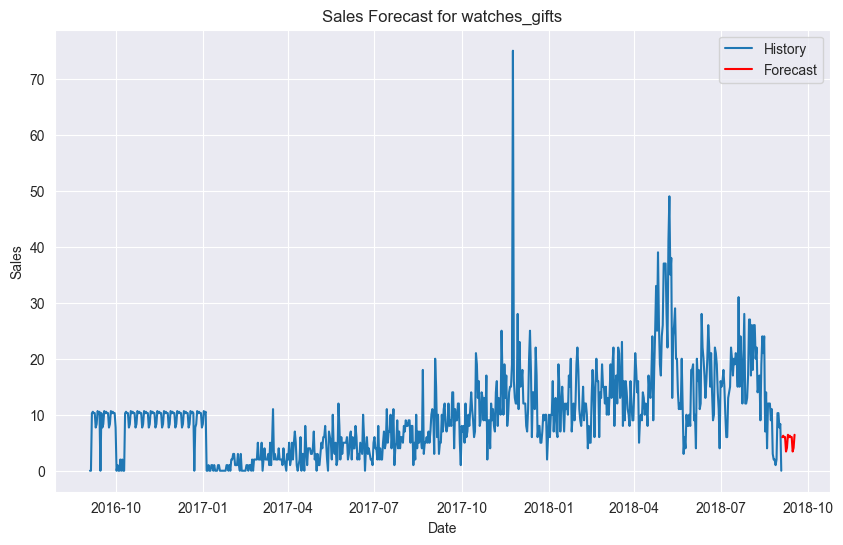

            agro_industry_and_commerce  air_conditioning       art  \
2018-09-04                    0.502201          0.806178  0.316959   
2018-09-05                    0.651452          0.725590  0.305425   
2018-09-06                    0.531870          0.536592  0.312627   
2018-09-07                    0.519886          0.604645  0.187615   
2018-09-08                    0.305540          0.449344  0.201789   
2018-09-09                    0.313380          0.542488  0.331840   
2018-09-10                    0.522419          0.448604  0.360881   
2018-09-11                    0.502201          0.806178  0.316959   
2018-09-12                    0.651452          0.725590  0.305425   
2018-09-13                    0.531870          0.536592  0.312627   
2018-09-14                    0.519886          0.604645  0.187615   
2018-09-15                    0.305540          0.449344  0.201789   
2018-09-16                    0.313380          0.542488  0.331840   
2018-09-17          

In [1]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Load data
orders = pd.read_csv('D:/Smart/S_Data/orders.csv')
order_items = pd.read_csv('D:/Smart/S_Data/order_items.csv')
products = pd.read_csv('D:/Smart/S_Data/products.csv')
product_category_name_translation = pd.read_csv('D:/Smart/S_Data/product_category_name_translation.csv')

# Translate product category names
products = products.merge(product_category_name_translation, on='product_category_name', how='left')

# Merge data
orders_items_merged = pd.merge(order_items, orders, on='order_id')
data = pd.merge(orders_items_merged, products, on='product_id')

# Prepare data, change the date accuracy to days
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
data.sort_values('order_purchase_timestamp', inplace=True)
data.set_index('order_purchase_timestamp', inplace=True)

# Group data by day and product category, make categories as columns and days as rows
daily_sales = data.groupby([pd.Grouper(freq='D'), 'product_category_name_english'])['order_item_id'].count().unstack().fillna(0)


# Ensure the index has daily frequency
daily_sales = daily_sales.asfreq('D')


# Function to fill missing values with the mean of the same weekday
def fillna_by_weekday(df):
    return df.fillna(df.groupby(df.index.dayofweek).transform('mean'))


# Apply the function to each column
daily_sales = daily_sales.apply(fillna_by_weekday, axis=0)

# Generate forecasts
categories = daily_sales.columns
forecasts = pd.DataFrame(index=pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=14, freq='D'))

for category in categories:
    try:
        # Create and fit the model
        model = ExponentialSmoothing(daily_sales[category], seasonal='add', seasonal_periods=7).fit()
        # Forecast for the next 14 days
        forecast = model.forecast(steps=14)
        forecasts[category] = forecast

        # Plot the historical data and forecast
        plt.figure(figsize=(10, 6))
        plt.plot(daily_sales[category], label='History')
        plt.plot(forecast.index, forecast, label='Forecast', color='red')
        plt.legend()
        plt.title(f'Sales Forecast for {category}')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.show()
    except Exception as e:
        print(f"Error processing category {category}: {e}")

print(forecasts)
